### <a id="train"> Keep on Training

Practice with feedback is the stepping stones towards Mastery and Happiness. This dataset was used in 2013 to introduce Word Vectors, and its uses to the masses. Today I am going to practice advance laguage models provided by Spacy. 

Task is to classify the sentiments of the review. The corpus offers wealth of text data to use the Spacy's function to learn and extract information about the reviews without fully reading them.

[Use Spacy's tokenizer to count the words in the corpus](#cnt)

[Visualising the sentences using Displacy](#sent)

[Vectorize the words and prepare them for PCA](#vect)

[Infering from PCA charts](#pca)

[Create Train / Validation set for ML](#TML)

[Training on MLP, KNN and Random Forest Classifiers](#ML)
    
[Training on LSTM](#Lstm)    

In [ ]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
test_data = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip',
                        compression='zip',sep='\t')

In [ ]:
labeled_data = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip',
                          compression='zip', sep ='\t')
labeled_data.head(2)

In [ ]:
from bs4 import BeautifulSoup             
import re
import spacy
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

In [ ]:
nlp = spacy.load('en_core_web_lg') #Loading the large corpus of the spacy model

In [ ]:
from collections import Counter

doc = nlp(labeled_data.review[0])

#get the length of the review. This will be required in later sections when dealing with LSTM, Transformers
print('There are {} tokens in this document'.format(len(doc)))
for token in doc[:10]: #print 1st 10 tokens
    print(token.text)

[Back to Top](#train)

### <a id="cnt"> Counting the tokens in the sentences

In [ ]:
# What is the review about? Using the texts
texts = [token.text for token in doc]
common_text = Counter(texts)

print('Most common words in the review {}'.format(common_text.most_common(5)))

In [ ]:
# What is the review about? Using the entities in the review.
entities = [ent.text for ent in doc.ents]
common_ents = Counter(entities)

print('Most common entities in the review {}'.format(common_ents.most_common(5)))

[Back to Top](#train)

### <a id="sent"> Visualising the sentences

In [ ]:
sent = [sent for sent in doc.sents]
sent[0]

visualising one sentence of the review using dependency visualisation. The server instance needs to be closed, so notebook execution can get stuck at this cell.

spacy.displacy.serve(sent[0], style="dep")

### Lets visualise the entities in the review using displacy

The below command will serve the image in the notebook, but beware the server doesn't let the notebook execution to proceed further. I was stuck for a very longgggg time... 

spacy.displacy.serve(doc, style="ent")

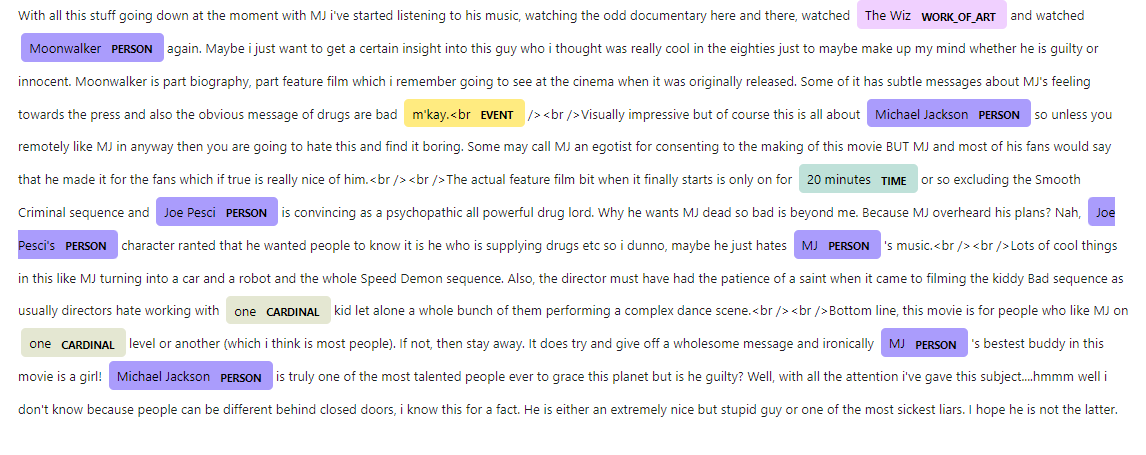

In [ ]:
#How is the distribution of the data? The dataset is balanced
labeled_data.groupby('sentiment').count()

[Back to Top](#train)

### <a id="vect"> Vectorising the words for PCA

Visualisation at the POS, Entity level is giving some info about the review, but the information is not 
sufficient for making the sentiment prediction. Lets turn to the statistical methods of looking at the reviews. We need to convert the words into numbers. 

Enter the vectors

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
#look at some vectors of the words
for word in doc[:5]:
    if word.has_vector:
        print(len(word.vector), word.vector[:5]) 
#Each word comprises of 300 dimensions, and sentences contains multiple words. Vectors of 5 words listed

In [ ]:
#vstack method changes the shape of the matrix that is formed by default idiom
np.vstack([word.vector for word in doc[:5] if word.has_vector]).shape

In [ ]:
# Initialize the BeautifulSoup object on the review and parse it for the text
example1 = BeautifulSoup(labeled_data["review"][0])  
review_pos = example1.get_text()
doc = nlp(review_pos)

In [ ]:
words = [word.text for word in doc if word.has_vector]

In [ ]:
#Looking at the words that have no vectors.Only one of the words have no vectors. Not bad 
[word.text for word in doc if not word.has_vector]

In [ ]:
#Make sure to send the nlp object below, since the vectors are in-built.
vecs = np.vstack([word.vector for word in doc if word.has_vector])
pca = PCA(n_components=2)
vecs_transformed = pca.fit_transform(vecs)

In [ ]:
pca_fig = px.scatter(x=vecs_transformed[:,0],y=vecs_transformed[:,1],
                     text = words)
pca_fig.update_traces(textposition="bottom right")
pca_fig.update_layout(title="PCA of a Positive review")
pca_fig.show()

In [ ]:
review_neg = labeled_data.loc[labeled_data.sentiment == 0,'review'].values[0]

review_neg = BeautifulSoup(review_neg).get_text() #get the cleaned text

#Create the NLP object
doc_neg = nlp(review_neg)

words = [word.text for word in doc_neg if word.has_vector] #get the words with vectors first

#Make sure to send the nlp object below, since the vectors are in-built.
vecs = np.vstack([word.vector for word in doc_neg if word.has_vector])

pca = PCA(n_components=2)

vecs_transformed = pca.fit_transform(vecs)

In [ ]:
pca_fig = px.scatter(x=vecs_transformed[:,0],y=vecs_transformed[:,1],
                     text = words)
pca_fig.update_traces(textposition="bottom right")
pca_fig.update_layout(title="PCA of a Negative review")
pca_fig.show()

[Back to Top](#train)

### <a id="pca"> Infering the PCA chart

PCA chart lists the words that are used in the reviews are very different. The words that describe something is plotted between 1 to 3 in the x-axis, and words location on y-axis is positive side for positive words, and negative side for negative sounding words...


After all the vectors of the words seem to provide a viable way to classify the reviews. Lets forge ahead with vectorising the reviews and then run usual machine learning algorithms. Before that, we have to divide the training data into training and validation set.

[Back to Top](#train)

### <a id="TML"> Creating Train and Validation data for ML


Then our game plan will be to work on 3 different ML libraries to classify the reviews. 

Decision Tree

MLP Classifier

Random Forest Classifier

LSTM Classifier

After completing the analysis, the best performing model will be used to train on the complete labeled_data. That model will be used to predict the sentiments of the test reviews and notebook submittted.  

In [ ]:
#splitting the training dataset, 20000 in to train and 5000 in valid. Splitting it here has its own benefits 
# drawbacks. 

train = labeled_data[:2000] 
print(train.shape)
valid = labeled_data[2000:3000]
print(valid.shape)

Storing the vectors to feed into the machine learning as features is a challenge, which is managed 
differently for different ML models

In [ ]:
#all_vectors is the training data of 2000 reviews
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0)*pd.np.ones((300)) \
                           for s in train['review']])

In [ ]:
#test_vectors is validation data of 1000 reviews
test_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0)*pd.np.ones((300)) \
                           for s in valid['review']])

In [ ]:
#pred_vectors are used for final submission
pred_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0)*pd.np.ones((300)) \
                           for s in test_data['review']])

In [ ]:
#visualising how the vectors will be entering into the model for training is very important
all_vectors[1].shape

In [ ]:
Y_train= train["sentiment"] #Make the sentiment as target to be predicted, Y
X_train = all_vectors # The vectors created from the words are going to be X

In [ ]:
Y_test= valid["sentiment"] #Make the sentiment as target to be predicted, Y
X_test = test_vectors # The vectors created from the words are going to be X

In [ ]:
#Creating full labelled data set for final model training.
labeled_X = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0)*pd.np.ones((300)) \
                           for s in labeled_data['review']])
labeled_y = labeled_data['sentiment']

[Back to Top](#train)

### <a id="ML"> Training the KNN, MLP and Random Forest
    
    The MLP classifier seems to be performing well on the validation test, after doing the Kfold cross validation.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction. 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras import optimizers

# Load libraries
import statsmodels.api as sm
import datetime
from datetime import date
#Additional Libraries 
import json  
import zipfile
import os.path
import sys

In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('KNN', KNeighborsClassifier()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
models.append(('RF', RandomForestClassifier()))

In [ ]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

### Which model is better among the 3? 
    
    Why not all model? All the 3 models will be trained on the full training data, and then test data set will be used for prediction and submission

In [ ]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

[Back to Top](#train)

### <a id="pred"> Creating full models with the full labeled dataset

In [ ]:
predict_results = []
for name,model in models:
    res = model.fit(labeled_X, labeled_y)
    model_result = res.predict(pred_vectors)
    predict_results.append(model_result)
    print('Completed predicting for {} model'.format(name))

In [ ]:
#creating the dataframe with id and targets predicted.
KN_sub = pd.DataFrame({'id': test_data.id, 'sentiment': predict_results[0]})
# you could use any filename. We choose submission here
KN_sub.to_csv('KN_sub.csv', index=False)

NN_sub = pd.DataFrame({'id': test_data.id, 'sentiment': predict_results[1]})

NN_sub.to_csv('NN_sub.csv', index=False)

RF_sub = pd.DataFrame({'id': test_data.id, 'sentiment': predict_results[2]})

RF_sub.to_csv('RF_sub.csv', index=False)

We have achieved a significant progress in moving from mere words to vectors,and transitioning from there to classifying thousands of reviews, and their sentiments. The accuracy still can be improved, and that is attempted in this notebook using the LSTM deep learning model

https://www.kaggle.com/kamaljp/learning-nlp-classification-lstm

[Back to Top](#train)